<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_4_SRAL_tracks.ipynb"><< SRAL tracks</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_6_SRAL_SSHA.ipynb">SRAL sea surface height anomalies >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2023 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Ben Loveday (EUMETSAT/Innoflair UG), Hayley Evers-King (EUMETSAT), Vinca Rosmorduc (CLS)

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-sral/HEAD?urlpath=%2Ftree%2F1_SRAL_introductory%2F1_5_SRAL_waveforms.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
  <div style="width:100%">
    <div style="float:left"><a href="https://jupyterhub-wekeo.apps.eumetsat.dpi.wekeo.eu/hub/user-redirect/lab/tree/public/wekeo4oceans/learn-sral/1_SRAL_introductory/1_5_SRAL_waveforms.ipynb"><img src="https://img.shields.io/badge/launch-WEKEO-1a4696.svg?style=flat&logo=" alt="Open in WEkEO"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>    
</html>

<div class="alert alert-block alert-success">
<h3>Learn SRAL: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1a_SRAL_data_access_Data_Store.ipynb" target="_blank">1_1a_SRAL_data_access_Data_Store.ipynb</a>** if using the Data Store for data access
    <br><br>**OR**<br><br>
  - **<a href="./1_1b_SRAL_data_access_HDA.ipynb" target="_blank">1_1b_SRAL_data_access_HDA.ipynb</a>** if using WEkEO for data access
    
</div>
<hr>

# 1.5 SRAL waveforms 


### Data used

| Product Description  | Data Store collection ID| Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:--------:|
| Sentinel-3 SRAL level-1B | EO:EUM:DAT:0406 |<a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:SR_1_SRA___NTC?query=SRAL&s=advanced" target="_blank">link</a> | EO:EUM:DAT:SENTINEL-3:SR_1_SRA___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3ASR_1_SRA___" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know;
* What an altimetry waveform is.
* What characteristics of the waveform can be used to derive different geophysical properties.
* How altimetry waveforms look in different measurement modes.
* What waveforms look like over different surfaces.


### Outline

Radar altimeters emit a pulse and then wait to recieve the echo of this signal after it has bounced off the Earth surface. The return echo - also known as a 'waveform' contains information not just about the relative distance between the altimeter and the surface, but also about the characteristics of the surface.

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
 
 0. [A quick preamble on functions](#section0)
 1. [What are waveforms?](#section1)
 2. [Waveforms and modes](#section2)
 3. [Waveform changes by surface class](#section3)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
import cartopy                       # a library that support mapping
import matplotlib.pyplot as plt      # a library that support plotting
import xarray as xr                  # a library that supports using labelled, multidimensional arrays
import numpy as np                   # a library that provides support for array-based mathematics
import os                            # a library that allows us access to basic operating system commands
import warnings                      # a library that helps us manage warnings
warnings.filterwarnings('ignore')

Lets set a few plot parameters for use throughout this notebook

In [2]:
plt.rcParams.update({'font.size': 12})

<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. A quick preamble on functions
[Back to top](#TOC-TOP)

</div>

In Python, we typically import common functions from libraries. However we may also want to write short function in a notebook/script that we will reuse several times. Below is an example of defining a short function, that we will use later for normalisation.

In [3]:
def norm(y):
    """Quick exponential scaled, normalisation function"""
    y_scale = np.nan
    if np.isfinite(np.nanmax(y)):
        y_scale = int(np.log10(np.nanmax(y)))
    y = (y-np.nanmin(y)) / (np.nanmax(y) - np.nanmin(y))
    return y*y_scale

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. What are waveforms?
[Back to top](#TOC-TOP)

</div>

Figure 1 shows how the waveform is generated in the altimetry measurement process, and how this can vary between measurements made over calm and rougher waters. 

<img src='../img/waveforms_generated.png' align='centre' width='75%'></img><center>Figure 1: Altimetry measurement process and waveform generation over calm (left panel) and rough (right panel) seas (courtesy: http://www.altimetry.info/)</center>


Figure two shows a classic waveform shape and the major characteristics of the waveform that are used to derive useful geophysical information about the ocean surface.

<img src='../img/waveform.PNG' align='centre' width='75%'></img>
<center>Figure 2: Diagram of a typical altimetry waveform over the ocean.</center>

* epoch: at mid-height, this gives the time delay of the expected return of the radar pulse from the altimeter. This is estimate by an algorithm called a 'tracker'. This gives the time the radar pulse took to travel from the satellite to the surface (the 'range') and back again. From this we can calculate the sea surface height.
* P: the amplitude of the useful signal. This amplitude with respect to the emission amplitude gives the backscatter coefficient, sigma0. This can be useful for characterising the surface.
* leading edge slope: this can be related to the significant wave height (SWH)

For further information about altimetry measurement theory, visit the associated pages in the **<a href="https://eumetsatspace.atlassian.net/wiki/spaces/ALT/pages/1537343494/Altimetry+measurement+principles">EUMETSAT user support knowledge base</a>**.


<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Waveforms and modes
[Back to top](#TOC-TOP)

</div>

In the previous notebook we saw that each Sentinel-3 altimetry level-2 product comes with 3 different netcdf files. In the rest of this notebook we'll look at another one of the files - the enhanced measurement file that contains both high and low resolution data, as well as the waveforms. As before, we'll start by opening the data file.

In [4]:
# selecting SAFE directories
SAFE_directory = os.path.join(os.getcwd(), 'products', 
    'S3B_SR_2_WAT____20220218T110400_20220218T115102_20220316T035351_2822_062_365______MAR_O_NT_004.SEN3')
measurement_file = "enhanced_measurement.nc"

In [5]:
# read data
ds = xr.open_dataset(os.path.join(SAFE_directory, measurement_file))
ds.close()

Now that we've opened the data, we can plot the waveforms. In the cell below, we'll plot two waveforms from the same point in the track, one obtained from the pseudo low rate mode (PLRM), and the other, SAR (Ku) mode.

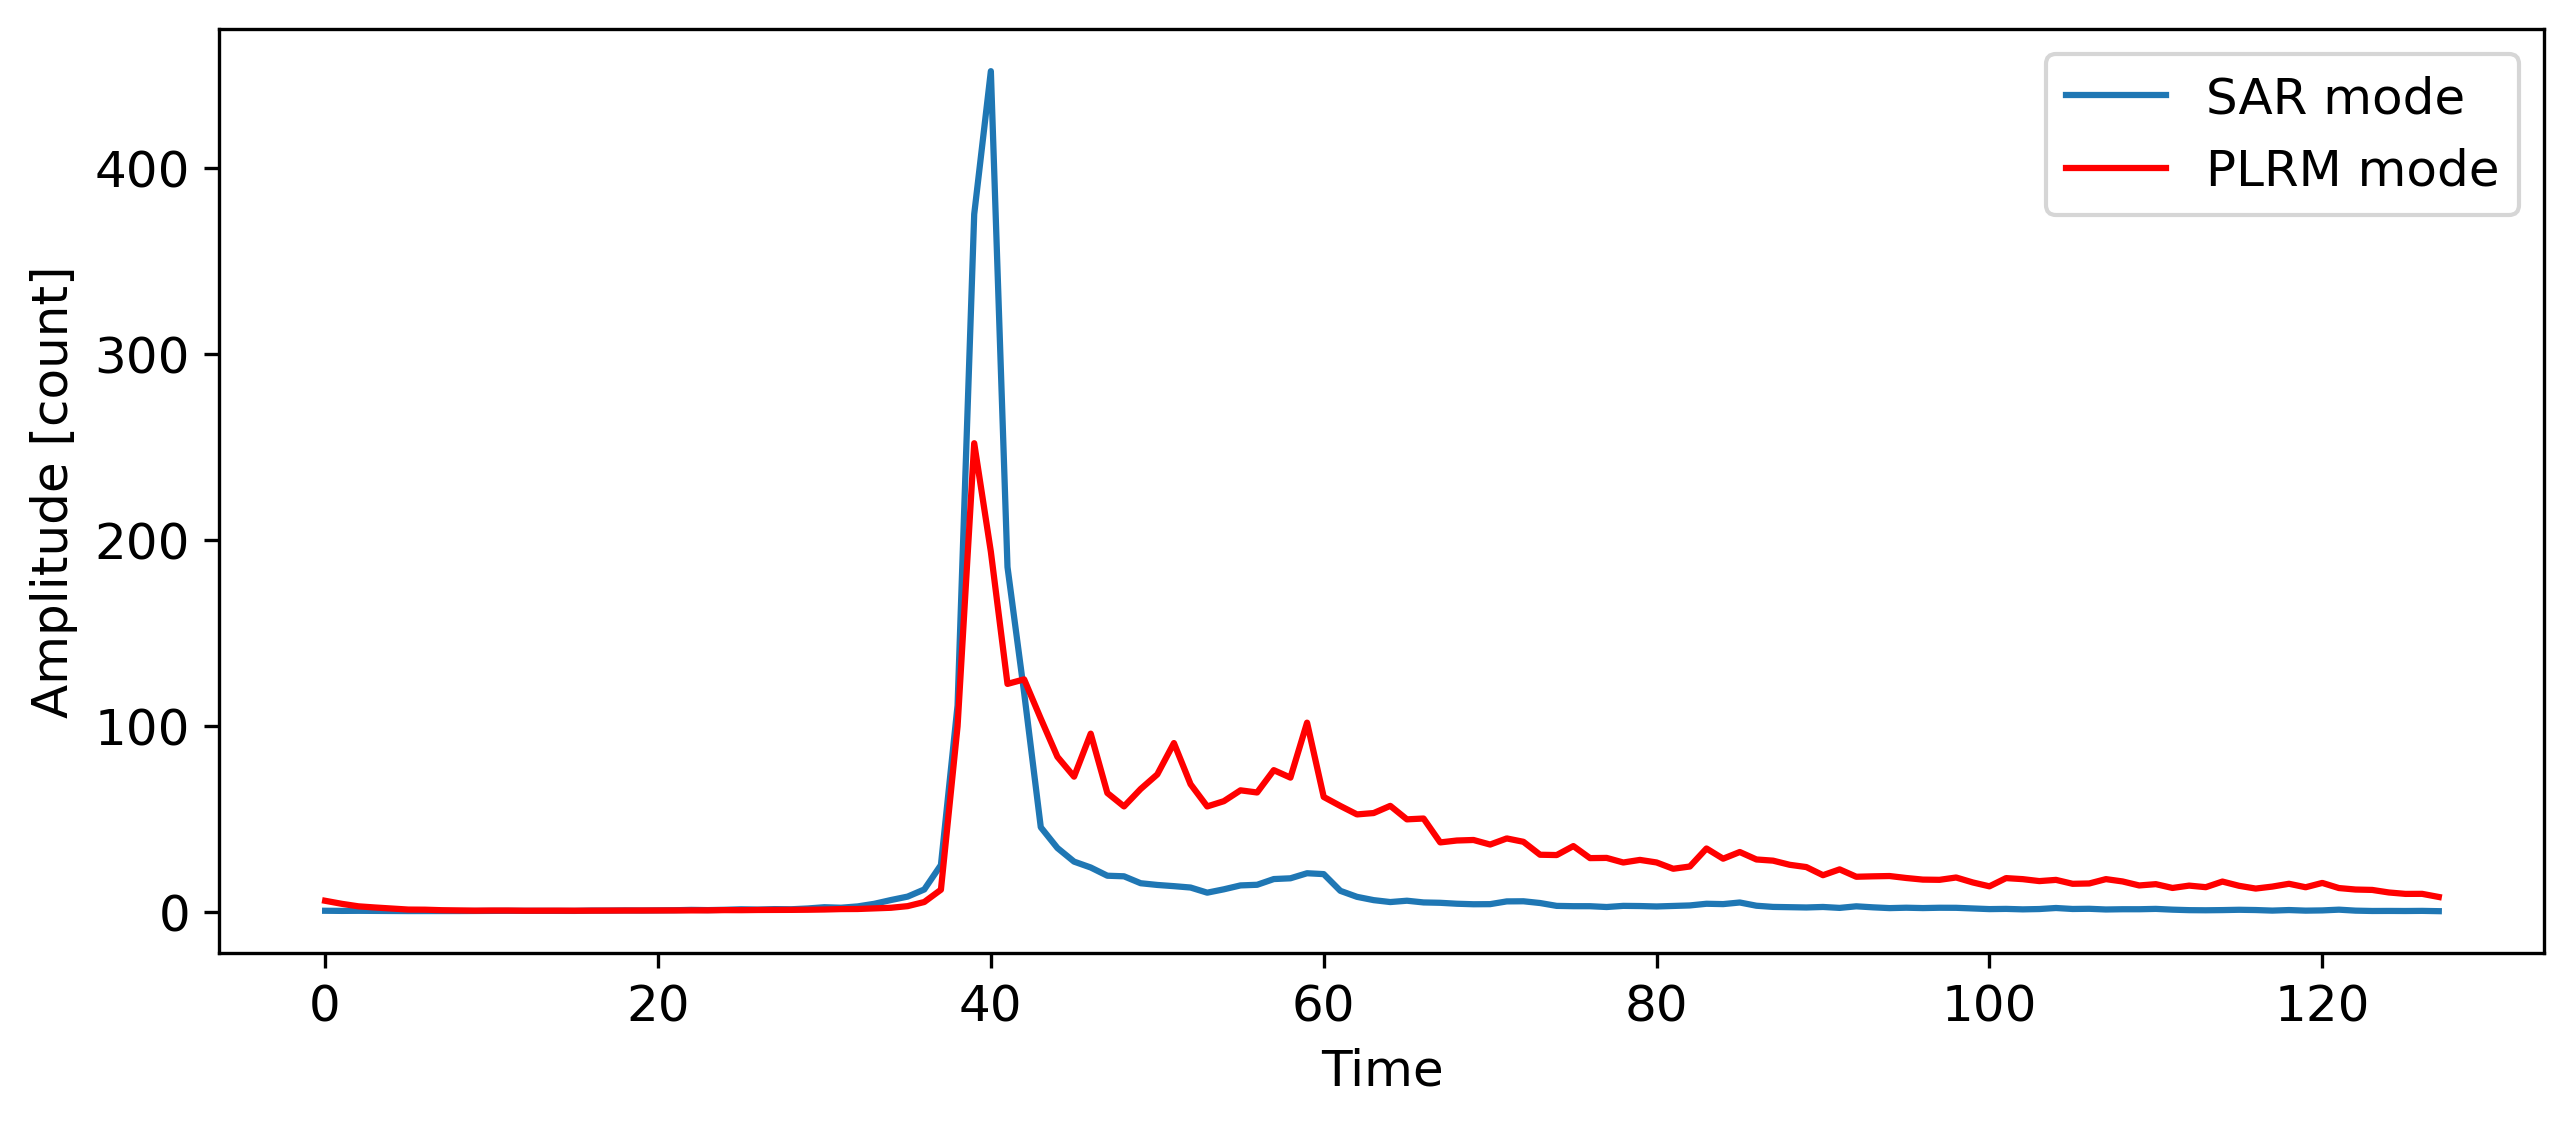

In [6]:
fig = plt.figure(figsize=(10, 4), dpi=300)
ax = plt.subplot(1,1,1)
p1, = ax.plot(ds["echo_sample_ind"], ds["waveform_20_ku"][3000,:], label='SAR mode')
p2, = ax.plot(ds["echo_sample_ind"], ds["waveform_20_plrm_ku"][3000,:],'r', label='PLRM mode')
plt.xlabel('Time')
plt.ylabel('Amplitude [count]')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.show()

In the plot we can see that the two waveforms are quite different. In general, SAR mode results in waveforms with a much more defined peak. This is a result of the finer along-track spatial resolution (300m) that can be achieved in this mode. This is particularly useful for complex domains such as near the coasts, the edges of ice etc. 

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Waveform changes by surface class
[Back to top](#TOC-TOP)

</div>

The processing mode is not the only thing than influences the waveform shape substantially. Different types of surface produce markedly different waveforms. Using the surface classification information provided in the Sentinel-3 level-2 altimetry products, the cell below plots a selection of waveforms associated with different surface classes. Note that again we are using waveforms from the SAR mode processing chain here (denoted by the ku in the variable name).

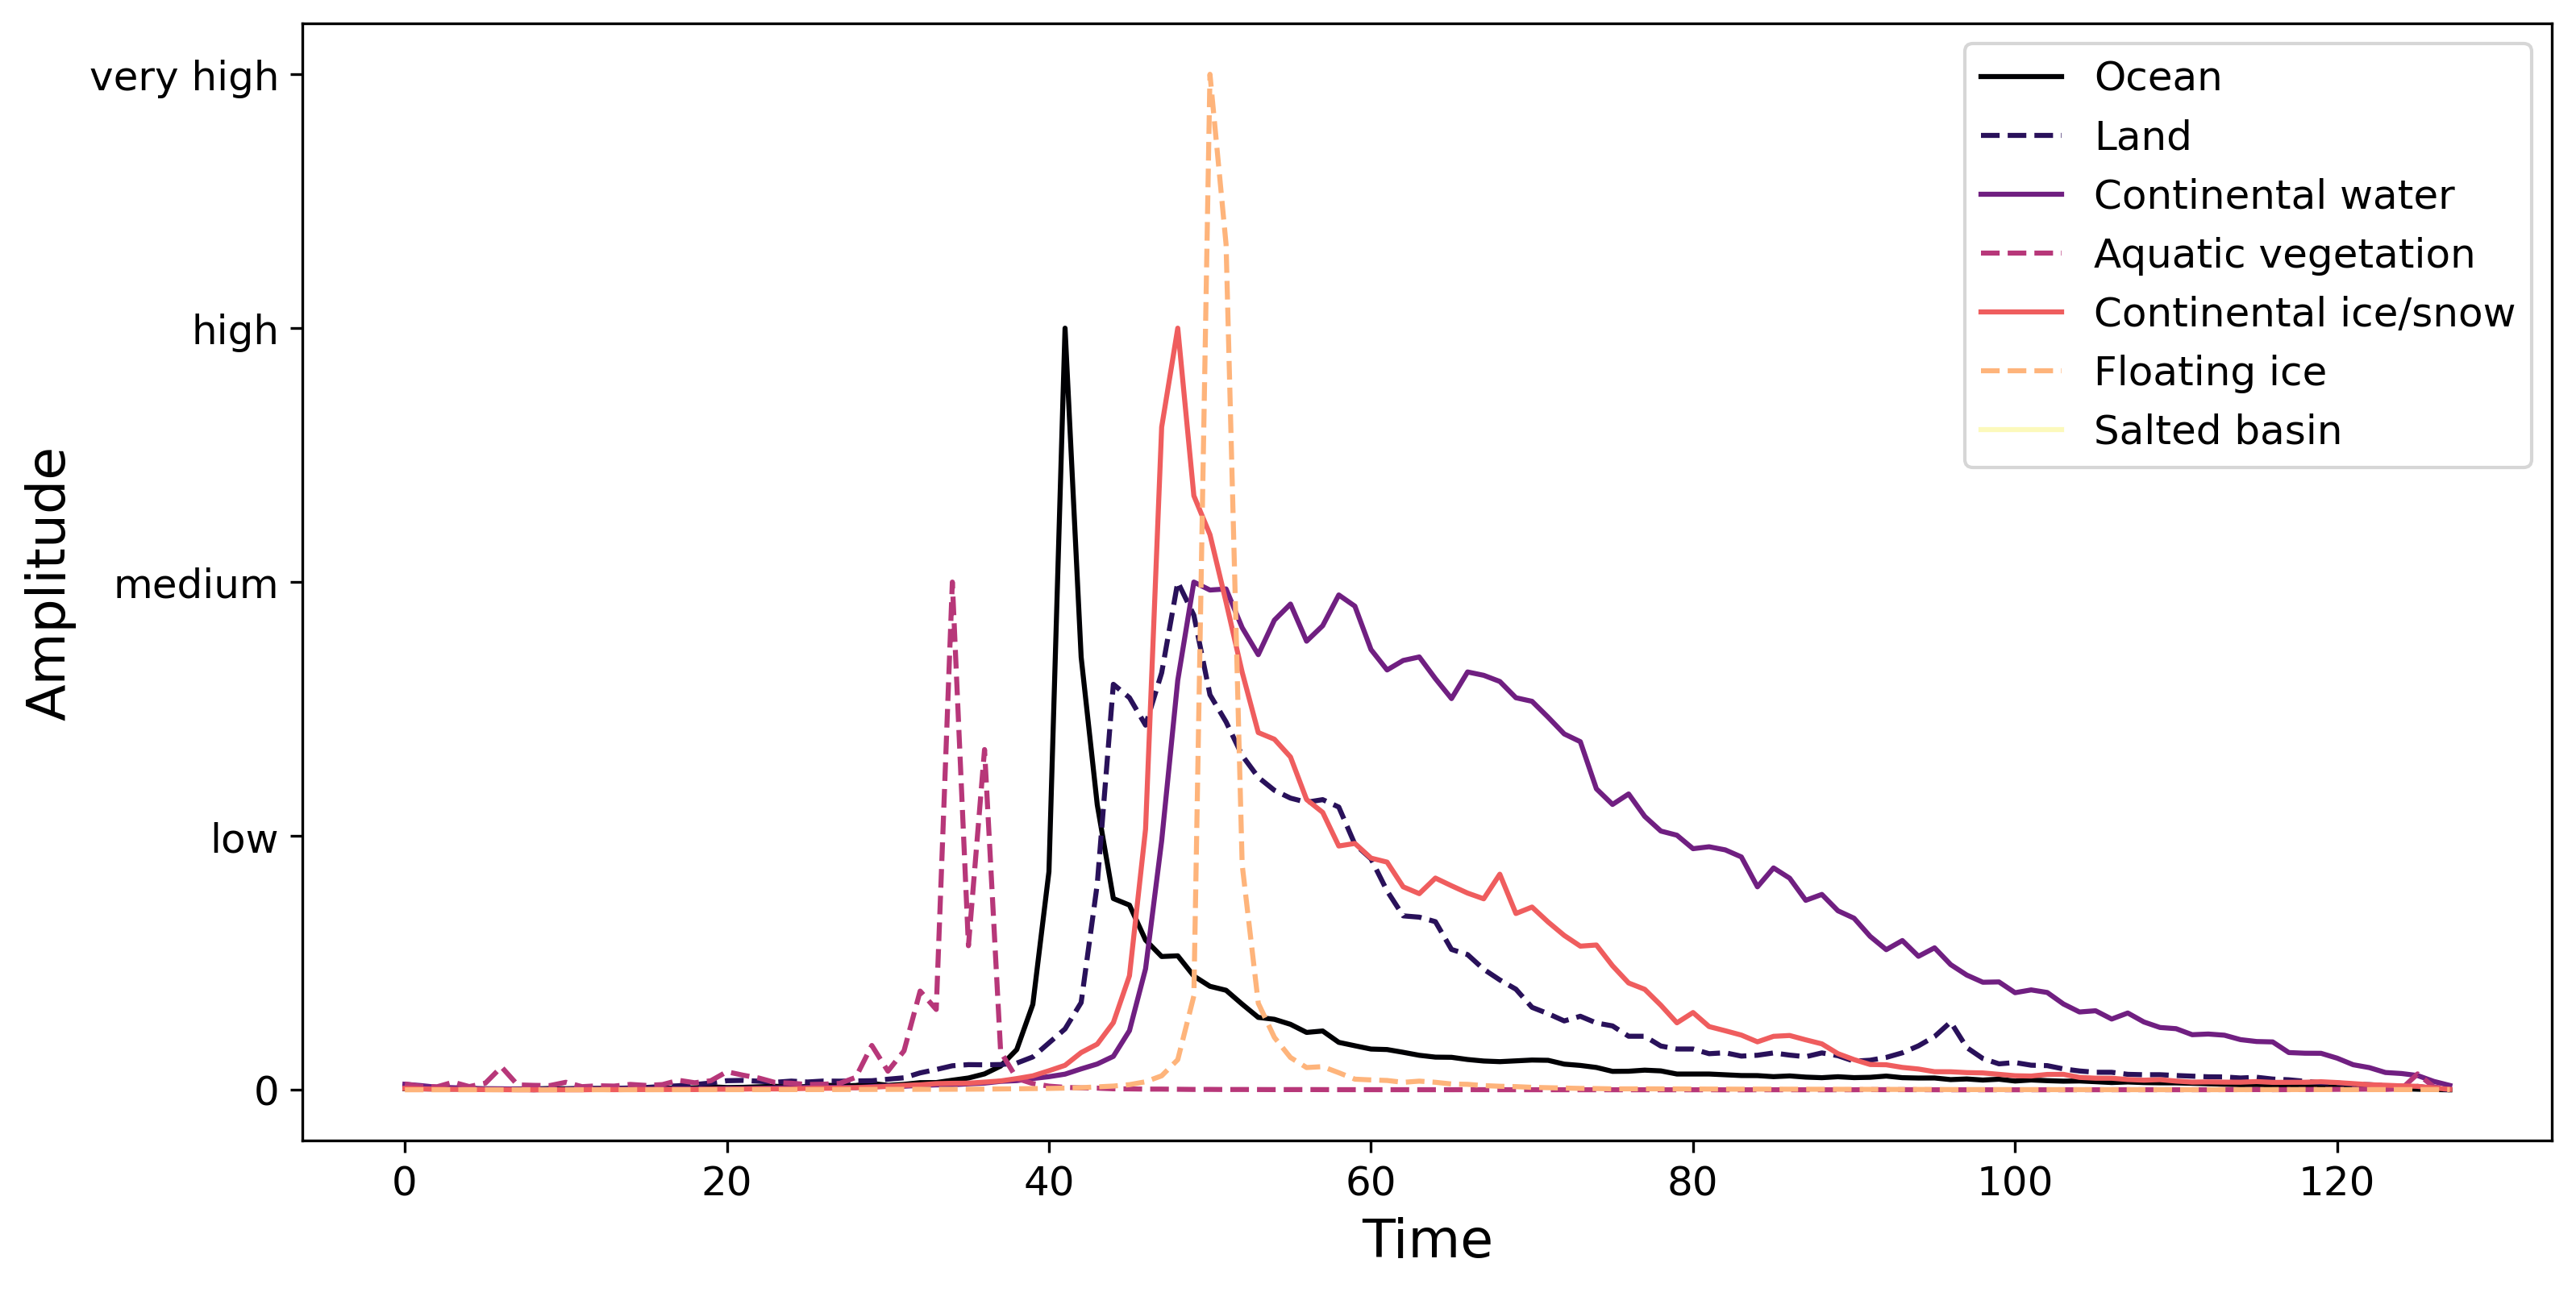

In [7]:
fig = plt.figure(figsize=(12, 6), dpi=300)

surf = np.array(ds["surf_class_20_ku"])
wf = np.array(ds["waveform_20_ku"])
cmap = plt.cm.magma
Xvals = ds["echo_sample_ind"]

p1, = plt.plot(Xvals, norm(np.nanmean(wf[np.where(surf == 0)[0][0:5], :], axis=0)), c=cmap(0))
p2, = plt.plot(Xvals, norm(np.nanmean(wf[np.where(surf == 1)[0][0:5], :], axis=0)), c=cmap(0.16), linestyle='--')
p3, = plt.plot(Xvals, norm(np.nanmean(wf[np.where(surf == 2)[0][0:5], :], axis=0)), c=cmap(0.33))
p4, = plt.plot(Xvals, norm(np.nanmean(wf[np.where(surf == 3)[0][0:5], :], axis=0)), c=cmap(0.5), linestyle='--')
p5, = plt.plot(Xvals, norm(np.nanmean(wf[np.where(surf == 4)[0][0:5], :], axis=0)), c=cmap(0.66))
p6, = plt.plot(Xvals, norm(np.nanmean(wf[np.where(surf == 5)[0][0:5], :], axis=0)), c=cmap(0.84), linestyle='--')
p7, = plt.plot(Xvals, norm(np.nanmean(wf[np.where(surf == 6)[0][0:5], :], axis=0)), c=cmap(0.99))

plt.yticks([0,1,2,3,4], ["0","low","medium","high","very high"])
plt.xlabel('Time', fontsize=16)
plt.ylabel('Amplitude',  fontsize=16)
plt.legend([p1, p2, p3, p4, p5, p6, p7],
           ['Ocean', 'Land', 'Continental water',
            'Aquatic vegetation', 'Continental ice/snow',
            'Floating ice', 'Salted basin'])
plt.show()

We can also look at the variability in the waveforms along the track. The cell below takes a portion of the track and plots all the associated waveforms.

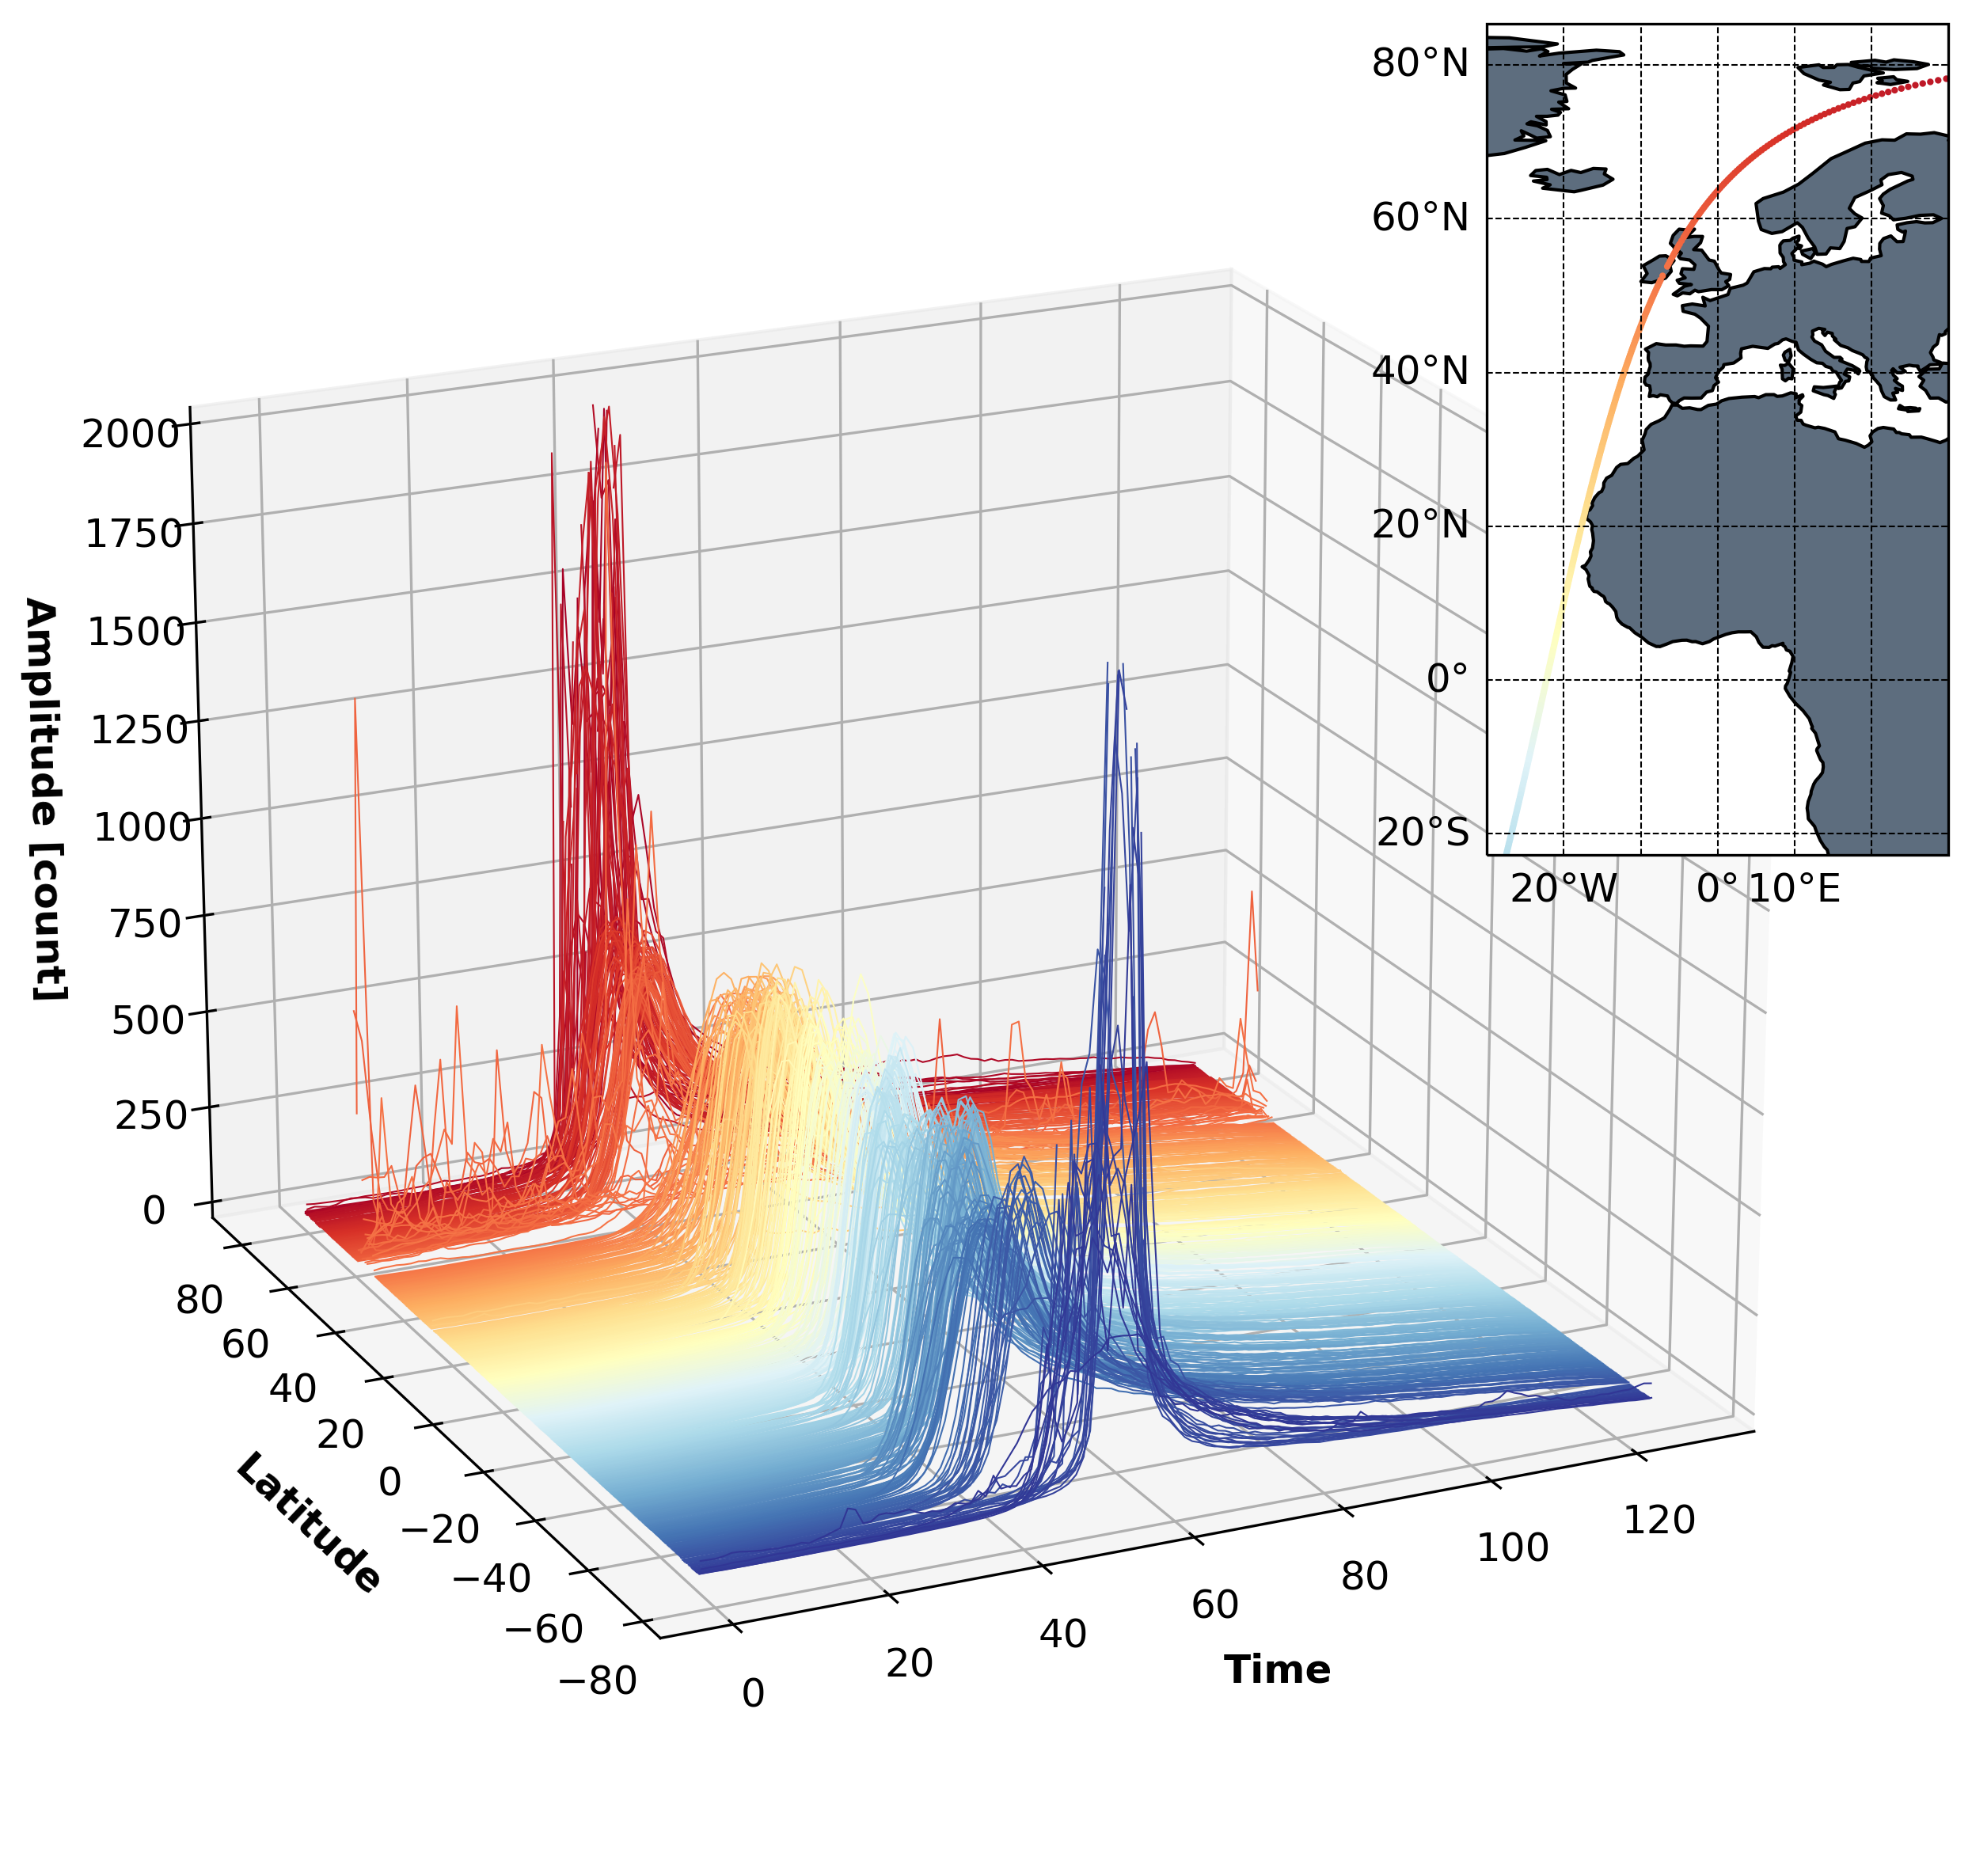

In [8]:
fig = plt.figure(figsize=(12, 10), dpi=300)
ax1 = fig.add_subplot(1, 1, 1, projection='3d')

cap = 2000
stride = 100
counter = int(np.shape(ds["waveform_20_ku"])[0]/stride)
waveform_array = np.zeros((counter, len(ds["echo_sample_ind"])))
lon_array = []
lat_array = []
cmap = plt.cm.RdYlBu

all_lons = ds["lon_20_ku"]
all_lons[all_lons > 180] = all_lons[all_lons > 180] - 360
all_lats = ds["lat_20_ku"]

for ii in range(counter):
    waveform_array[ii, :] = np.nanmean(ds["waveform_20_ku"][ii*stride:(ii+1)*stride, :], axis=0)
    waveform_array[waveform_array > cap] = np.nan
    lons = np.nanmean(all_lons[ii*stride:(ii+1)*stride])
    lats = np.nanmean(all_lats[ii*stride:(ii+1)*stride])
    lon_array.append(lons)
    lat_array.append(lats)
    p1, = ax1.plot3D(ds["echo_sample_ind"], np.ones(len(ds["echo_sample_ind"]))*lats,
                    waveform_array[ii, :], color=cmap(ii/counter), linewidth=0.5, zorder=ii)

ax1.set_zlim([0, cap])
ax1.view_init(elev=20, azim=245)
ax1.set_xlabel('Time', fontweight='bold', labelpad=10)
ax1.set_ylabel('Latitude', fontweight='bold', labelpad=10)
ax1.set_zlabel('Amplitude [count]', fontweight='bold', labelpad=10)

ax2 = fig.add_subplot(2, 3, 3, projection=cartopy.crs.PlateCarree())
ax2.scatter(lon_array, lat_array, 1, range(len(lon_array)), cmap=cmap)
ax2.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
g1 = ax2.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
g1.top_labels = False
g1.right_labels = False
g1.xlabel_style = {'color': 'black'}
g1.ylabel_style = {'color': 'black'}
ax2.set(facecolor = "1.0")
ax2.set_extent([-30, 30, -20, 85])
plt.savefig('1_5_SRAL_waveforms.png')

Over the track we can see how the waveform change shape notably in areas where the track is likely to be crossing areas with ice, and areas of land.

In the next notebook we'll look more closely at how we can use waveforms like those in the centre of this track, that cover the ocean to derive the key parameter for altimetry missions - sea surface height.

<hr>
<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_4_SRAL_tracks.ipynb"><< SRAL tracks</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_6_SRAL_SSHA.ipynb">SRAL sea surface height anomalies >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean" target="_blank">View on GitLab</a> | <a href="https://training.eumetsat.int/" target="_blank">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int target="_blank">Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int target="_blank">Contact our training team to collaborate on and reuse this material</a></span></p>